In [30]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm
from scipy.stats import ttest_ind
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from datetime import datetime, timedelta
from dateutil.parser import parse
import math
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import os

import matplotlib.pyplot as plt

 
%matplotlib inline

In [34]:
plt.rcParams["figure.figsize"] = (20,10)
ufo = pd.read_csv('/Users/richardlafferty/Downloads/scrubbed.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [89]:
print(ufo.datetime.head())

0    10/10/1949 20:30:00
1    10/10/1949 21:00:00
2    10/10/1955 17:00:00
3    10/10/1956 21:00:00
4    10/10/1960 20:00:00
Name: datetime, dtype: object


In [65]:
ufo.rename(columns = {'duration (seconds)':'duration_seconds',
                      'duration (hours/min)': 'duration_hrs_min',
                      'date posted': 'date_posted'}, inplace = True)

In [117]:
ufo['date'] = ufo['datetime'].map(lambda x: str(x)[:-8])
ufo['date'] = ufo['date'].str.strip()
ufo['year'] = ufo['date'].map(lambda x: str(x)[-4:])
ufo['year'] = ufo['year'].str.split('/')
ufo['time'] = ufo['datetime'].map(lambda x: str(x)[-8:])


In [118]:

print(ufo.date.head())
print(ufo.year.head())
print(ufo.time.head())


0    10/10/1949
1    10/10/1949
2    10/10/1955
3    10/10/1956
4    10/10/1960
Name: date, dtype: object
0    [1949]
1    [1949]
2    [1955]
3    [1956]
4    [1960]
Name: year, dtype: object
0    20:30:00
1    21:00:00
2    17:00:00
3    21:00:00
4    20:00:00
Name: time, dtype: object


In [42]:
ufo['latitude'] = pd.to_numeric(ufo['latitude'], errors = 'coerce')


In [43]:
ufo.rename(columns = {'longitude ': 'longitude'}, inplace = True)

In [44]:
print(ufo['latitude'].mean())
print(ufo['longitude'].mean())
print(ufo['latitude'].median())
print(ufo['longitude'].median())


38.12447682461752
-86.77288454711757
39.41111110000001
-87.90361109999999


In [45]:
print(ufo.dtypes)

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                float64
longitude               float64
date                     object
year                     object
dtype: object


In [122]:
for row_num, row in enumerate(ufo, start=1):
    try:
        pd.to_datetime(ufo.datetime, infer_datetime_format = True)
    except ValueError as err:
        print("Invalid data, row is skipped")
        print('Row: {}, Reason : {}'.format(row_num, err))
       
   

Invalid data, row is skipped
Row: 1, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 2, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 3, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 4, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 5, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 6, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 7, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 8, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 9, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 10, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 11, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 12, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 13, Reason : hour must be in 0..23
Invalid data, row is skipped
Row: 14, Reason : hour must be in 0..23


In [123]:
print (ufo[pd.to_datetime(ufo.datetime, errors='coerce').isnull()])

                  datetime                                city state country  \
388    10/11/2006 24:00:00                                rome    ny      us   
693     10/1/2001 24:00:00    chulucanas-piura la vieja (peru)   NaN     NaN   
962     10/1/2012 24:00:00                                novi    mi      us   
1067   10/12/2003 24:00:00                salatiga (indonesia)   NaN     NaN   
1221   10/12/2013 24:00:00                          cincinnati    oh      us   
1222   10/12/2013 24:00:00             orangevale (sacramento)    ca      us   
1317   10/13/2004 24:00:00                          white hall    ar      us   
1359   10/13/2007 24:00:00                              hudson    wi      us   
1445   10/13/2012 24:00:00                            kingston    pa      us   
1663   10/14/2011 24:00:00                   cibecue (west of)    az      us   
1709   10/15/1952 24:00:00    edmonton (southwest of) (canada)    ab      ca   
1754   10/15/1971 24:00:00            la

In [73]:
print(ufo['datetime'].head())

0    10/10/1949 20:30
1    10/10/1949 21:00
2    10/10/1955 17:00
3    10/10/1956 21:00
4    10/10/1960 20:00
Name: datetime, dtype: object


In [74]:
ufo['datetime'] = ufo['datetime'].apply(lambda x: x + ':00')

In [75]:
print(ufo['datetime'].head())

0    10/10/1949 20:30:00
1    10/10/1949 21:00:00
2    10/10/1955 17:00:00
3    10/10/1956 21:00:00
4    10/10/1960 20:00:00
Name: datetime, dtype: object


In [77]:
print(ufo.dtypes)

datetime             object
city                 object
state                object
country              object
shape                object
duration_seconds     object
duration_hrs_min     object
comments             object
date_posted          object
latitude            float64
longitude           float64
date                 object
year                 object
dtype: object


In [90]:
for row_num, row in enumerate(ufo, start=1):
    try:
        pd.to_numeric(ufo.duration_seconds)
    except ValueError as err:
        print("Invalid data, row is skipped")
        print('Row: {}, Reason : {}'.format(row_num, err))
    

Invalid data, row is skipped
Row: 1, Reason : Unable to parse string "2`" at position 27822
Invalid data, row is skipped
Row: 2, Reason : Unable to parse string "2`" at position 27822
Invalid data, row is skipped
Row: 3, Reason : Unable to parse string "2`" at position 27822
Invalid data, row is skipped
Row: 4, Reason : Unable to parse string "2`" at position 27822
Invalid data, row is skipped
Row: 5, Reason : Unable to parse string "2`" at position 27822
Invalid data, row is skipped
Row: 6, Reason : Unable to parse string "2`" at position 27822
Invalid data, row is skipped
Row: 7, Reason : Unable to parse string "2`" at position 27822
Invalid data, row is skipped
Row: 8, Reason : Unable to parse string "2`" at position 27822
Invalid data, row is skipped
Row: 9, Reason : Unable to parse string "2`" at position 27822
Invalid data, row is skipped
Row: 10, Reason : Unable to parse string "2`" at position 27822
Invalid data, row is skipped
Row: 11, Reason : Unable to parse string "2`" at p

In [96]:
print (ufo[pd.to_numeric(ufo.duration_seconds, errors='coerce').isnull()])

                 datetime               city state country   shape  \
27822   2/2/2000 19:33:00              bouse    az      us     NaN   
35692  4/10/2005 22:52:00         santa cruz    ca      us     NaN   
58591  7/21/2006 13:00:00  ibague (colombia)   NaN     NaN  circle   

      duration_seconds    duration_hrs_min  \
27822               2`  each a few seconds   
35692               8`       eight seconds   
58591             0.5`         1/2 segundo   

                                                comments date_posted  \
27822  Driving through Plomosa Pass towards Bouse Loo...   2/16/2000   
35692  2 red lights moving together and apart with a ...   4/16/2005   
58591  Viajaba a 27.000 pies en un avion comercial ve...  10/30/2006   

        latitude   longitude       date      year  
27822  33.932500 -114.005000   2/2/2000    [2000]  
35692  36.974167 -122.029722  4/10/2005  [, 2005]  
58591   4.440663  -75.244141  7/21/2006  [, 2006]  


In [46]:
print(ufo.columns.to_list())

['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)', 'duration (hours/min)', 'comments', 'date posted', 'latitude', 'longitude', 'date', 'year']


In [47]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world[world.name != 'Antarctica']

long_lat_points = [Point(xy) for xy in zip(ufo['longitude'], ufo['latitude'])]

crs = {"init": "epsg:4326"}


In [91]:
print(ufo.duration_seconds.head())

0    2700
1    7200
2      20
3      20
4     900
Name: duration_seconds, dtype: object


In [48]:
long_lat_points[:3]

In [94]:
shapes_seen = ufo.groupby('shape').shape.agg(['count'])

In [95]:
print(shapes_seen)

           count
shape           
changed        1
changing    1962
chevron      952
cigar       2057
circle      7608
cone         316
crescent       2
cross        233
cylinder    1283
delta          7
diamond     1178
disk        5213
dome           1
egg          759
fireball    6208
flare          1
flash       1328
formation   2457
hexagon        1
light      16565
other       5649
oval        3733
pyramid        1
rectangle   1297
round          2
sphere      5387
teardrop     750
triangle    7865
unknown     5584


In [ ]:
light = ufo.loc[ufo['shape'] == 'light']
changing = ufo.loc[ufo['shape'] == 'changing']
chevron = ufo.loc[ufo['shape'] == 'chevron']

In [51]:
median_sighting = Point(38.1244768246185, -86.7728845471172)

In [67]:
print(ufo.head())

           datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3  10/10/1956 21:00                  edna    tx      us    circle   
4  10/10/1960 20:00               kaneohe    hi      us     light   

  duration_seconds duration_hrs_min  \
0             2700       45 minutes   
1             7200          1-2 hrs   
2               20       20 seconds   
3               20         1/2 hour   
4              900       15 minutes   

                                            comments date_posted   latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.883056   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005  29.384210   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008  53.200000   
3  My older brother and twin siste

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


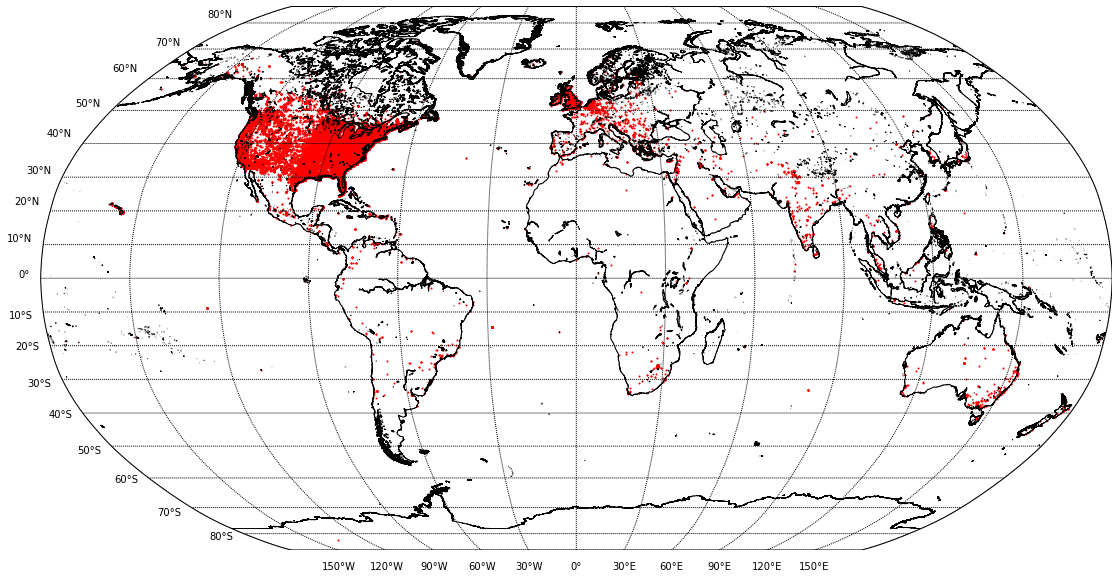

In [70]:
m = Basemap(projection='robin',lon_0=0,resolution='f')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])

m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 1, c = 'red')
plt.show()

In [57]:
light = ufo.loc[ufo['shape'] == 'light']

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


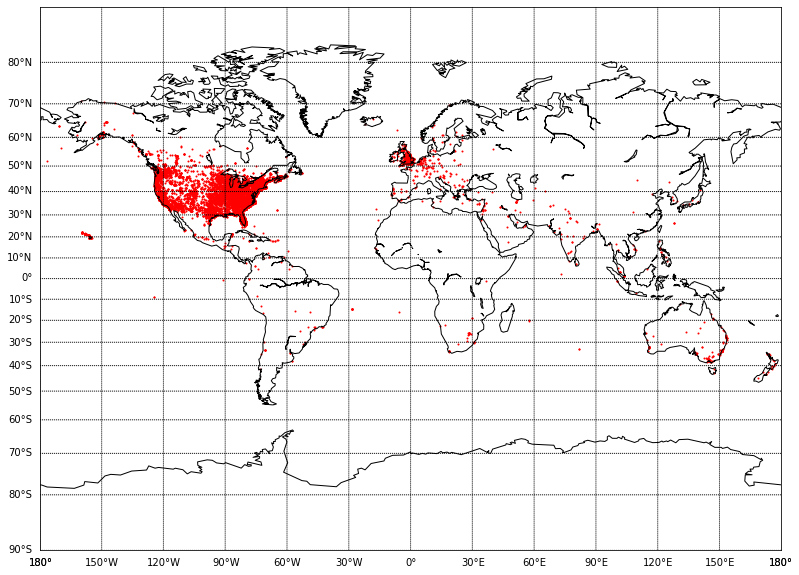

In [58]:
m = Basemap(projection = 'mill',
           llcrnrlat = -90,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])

m.scatter(light.longitude.to_list(), light.latitude.to_list(), latlon = True, s = 1, c = 'red')

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


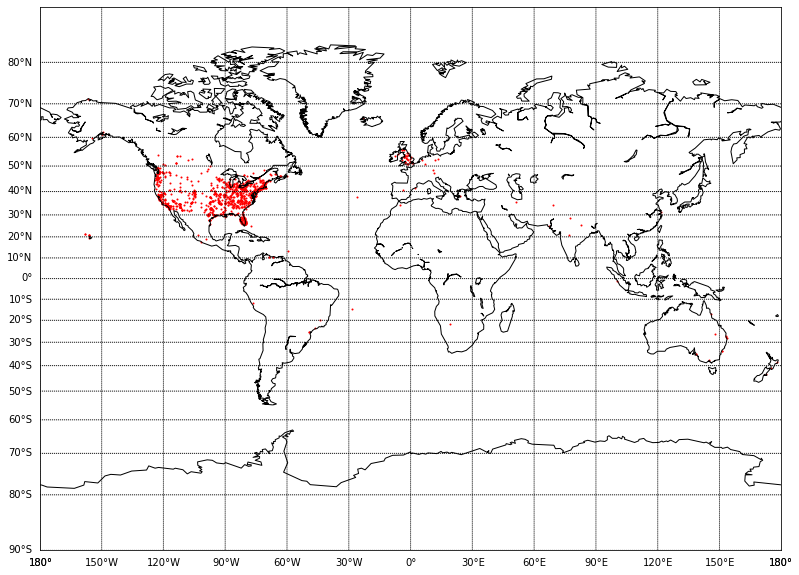

In [59]:
cylinder = ufo.loc[ufo['shape'] == 'cylinder']
m = Basemap(projection = 'mill',
           llcrnrlat = -90,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])
m.scatter(cylinder.longitude.to_list(), cylinder.latitude.to_list(), latlon = True, s = 1, c = 'red')


/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


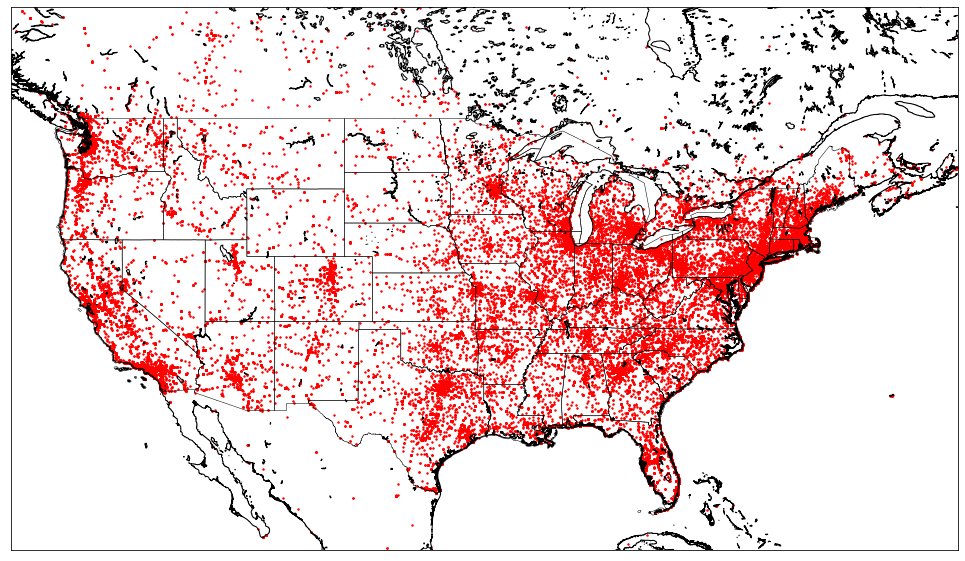

In [63]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'f')
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 2, c = 'red')


In [ ]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'c')
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')
m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 2, c = 'red')